In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from HTKFeat import MFCC_HTK

from pydub import AudioSegment
from pydub.playback import play

In [2]:
# The MFCC HTK class for MFCC feature extraction
mfcc = MFCC_HTK()
# Basic example
file_path = "data/happy_example.wav"
signal_raw = AudioSegment.from_file(file_path)
signal = np.frombuffer(signal_raw._data, dtype=np.int16).astype(np.double)
sig_len = signal.size/signal_raw.frame_rate

print(f"Frame rate: {signal_raw.frame_rate}")

Frame rate: 16000


In [3]:
play(signal_raw)

In [4]:
# here we load the raw audio file
sig = mfcc.load_raw_signal(file_path)

# here we calculate the MFCC+energy, deltas and acceleration coefficients
feat = mfcc.get_feats(sig)
delta = mfcc.get_delta(feat, 2)
acc = mfcc.get_delta(delta, 2)

# here we merge the MFCCs and deltas together to get 39 features per frame (25 ms)
feat = np.hstack((feat, delta, acc))

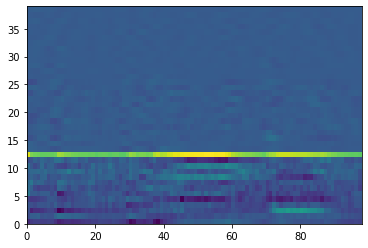

In [5]:
plt.pcolormesh(feat.T)

(0.0, 1.0)

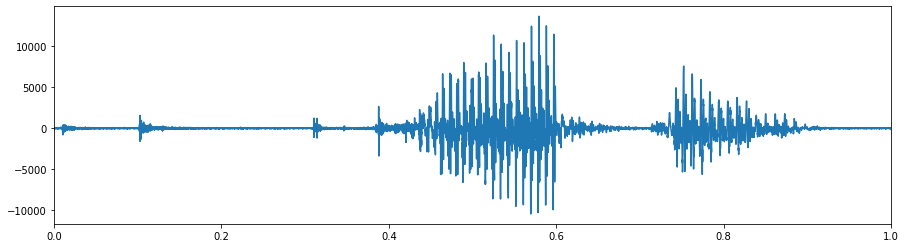

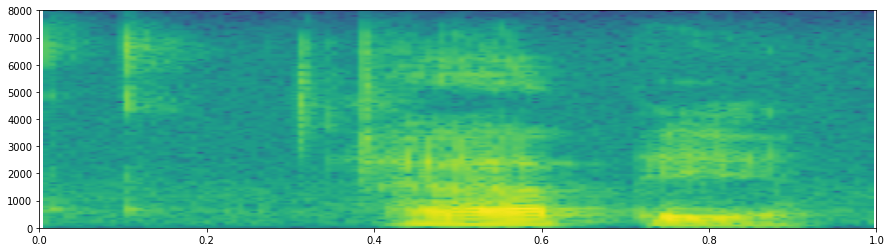

In [6]:
plt.figure(figsize=(15,4))
t = np.linspace(0, sig_len, signal.size)
plt.plot(t, signal)
plt.xlim(0,sig_len)
plt.figure(figsize=(15,4))
s=plt.specgram(signal, Fs=signal_raw.frame_rate)
plt.colormaps()
plt.xlim(0,sig_len)

### Start preprocessing

In [7]:
train_audio_path = './data/speech_commands_v0.01'

['no', 'seven', 'one', 'off', 'on', 'tree', 'left', 'stop', 'cat', 'zero', 'dog', 'marvin', 'go', 'nine', 'down', '_background_noise_', 'four', 'yes', 'eight', 'six', 'house', 'up', 'five', 'three', 'happy', 'bird', 'two', 'sheila', 'right', 'wow', 'bed']


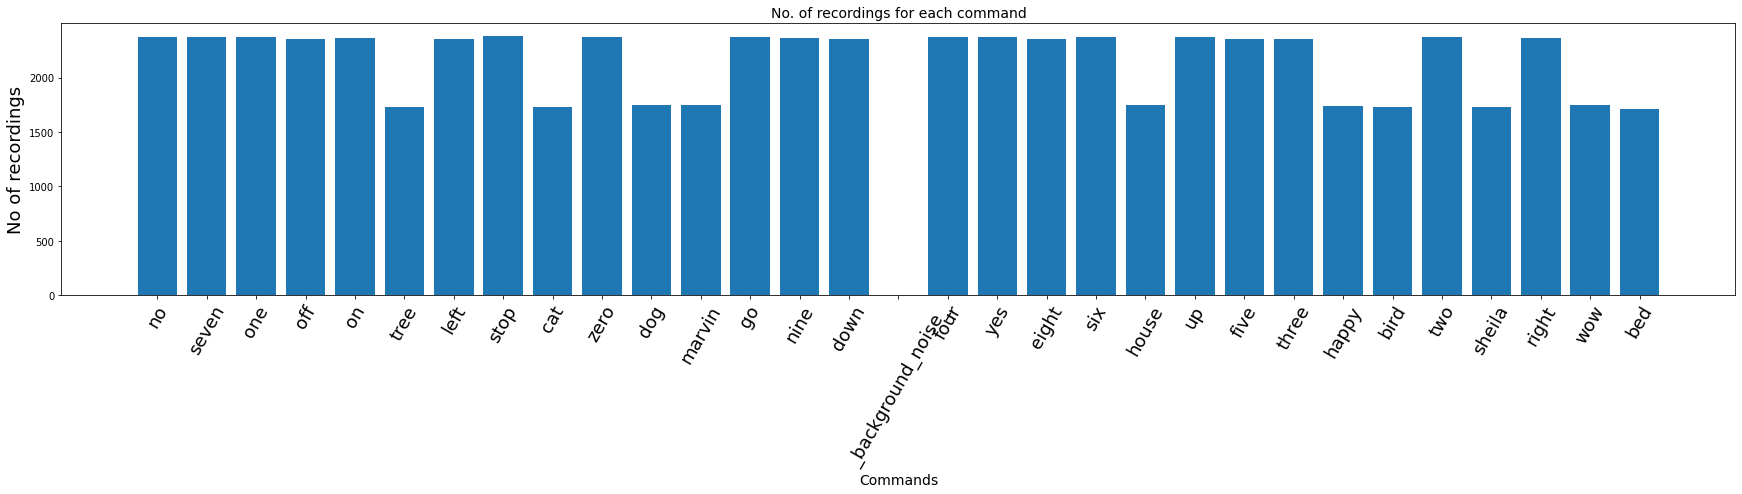

2380


In [8]:
labels=os.listdir(train_audio_path)
labels = [l for l in labels if not (l.endswith('.txt') or l.endswith('.md') or l.endswith('CENSE'))]
print(labels)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(os.path.join(train_audio_path, label)) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=14)
plt.ylabel('No of recordings', fontsize=18)
plt.xticks(index, labels, fontsize=18, rotation=60)
plt.title('No. of recordings for each command', fontsize=14)
plt.show()
print(max(no_of_recordings))

# On se limite à quelques catégories (sinon welcome trouble pour ta machine!)
labels=["yes", "no", "up", "down", "left"] #, "right", "on", "off", "stop", "go"]

11839


(array([6.0000e+00, 1.3000e+01, 1.1000e+01, 6.7000e+01, 7.9000e+01,
        8.5000e+01, 1.8800e+02, 2.3000e+02, 2.9400e+02, 1.0866e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

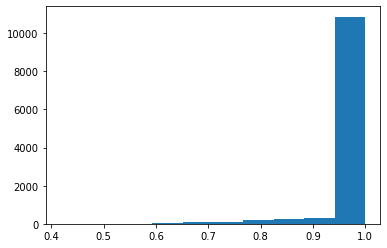

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(os.path.join(train_audio_path, label)) if f.endswith('.wav')]
    for wav in waves:
        samples = AudioSegment.from_file(os.path.join(train_audio_path, label, wav))
        duration_of_recordings.append(samples.duration_seconds)

print(len(duration_of_recordings))
plt.hist(np.array(duration_of_recordings))

Here are the two steps we’ll follow:

* Resampling
* Removing shorter commands of less than 1 second
* Compute the MFCC features

In [10]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(os.path.join(train_audio_path, label)) if f.endswith('.wav')]
    for wav in waves:
        file_path = os.path.join(train_audio_path, label, wav)
        samples = AudioSegment.from_file(file_path)
        # samples = samples.set_frame_rate(8000)
        if samples.duration_seconds >= 1:
            sig = mfcc.load_raw_signal(file_path)
            # here we calculate the MFCC+energy, deltas and acceleration coefficients
            feat = mfcc.get_feats(sig)
            delta = mfcc.get_delta(feat, 2)
            acc = mfcc.get_delta(delta, 2)

            # here we merge the MFCCs and deltas together to get NB (?) features
            feat = np.hstack((feat, delta, acc))
            all_wave.append(feat)
            all_label.append(label)
# print("")
print(f"\nNumber of kept files: {len(all_wave)}")
print(f"Number of removed files: {len(duration_of_recordings) - len(all_wave)}")

yes
no
up
down
left

Number of kept files: 10634
Number of removed files: 1205


### Encode labels numerically

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes = list(le.classes_)
print(classes, y)
print(len(y))

['down', 'left', 'no', 'up', 'yes'] [4 4 4 ... 1 1 1]
10634


In [12]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(all_wave, y, stratify=y, test_size = 0.9, random_state=42, shuffle=True)

print(len(x_tr))

1063


### Reformat the training and test data into the appropriate formats for Sklearn models

In [13]:
X_train, y_train = [], []
for x_t, y_t in zip(x_tr, y_tr):
    for a in x_t:
        X_train.append(a)
        y_train.append(y_t)
X_train[0], y_train[0]

(array([-1.00198915e+01, -3.83392805e-01, -3.53719416e+00, -7.26110759e+00,
        -1.75394272e+01,  2.18877703e-01, -2.39311664e+00,  1.13215738e+00,
         2.61183114e+00,  7.61363554e+00,  1.27027438e+01, -2.75185635e+00,
         7.55504235e+01,  3.81518120e+00,  4.58304256e-01, -1.91681546e+00,
        -1.29222662e+00,  3.74312450e+00, -1.17180532e+00, -1.71699973e+00,
        -1.42918859e+00,  1.43277328e+00,  1.86926063e+00, -2.97824218e+00,
         6.89808942e-01, -3.36202134e+00, -4.13410287e-01, -1.79142192e-01,
         2.78743476e-01, -9.83477900e-02, -8.87148027e-01, -3.34019704e-02,
         6.33701317e-01,  2.95504489e-01,  8.88636687e-02,  3.99187641e-02,
         5.09338133e-02, -2.14764269e-01,  1.29821740e-01]),
 1)

In [14]:
X_test, y_test = [], []
for x_t, y_t in zip(x_val, y_val):
    for a in x_t:
        X_test.append(a)
        y_test.append(y_t)
X_test[0], y_test[0]

(array([-1.75065153e+01, -6.09678705e+00, -3.56582392e+00, -1.87201787e+00,
        -7.92266334e+00,  1.22200216e+01,  7.07772425e+00,  3.42411310e+00,
        -1.77141736e+00,  9.47893110e-01,  8.25439003e+00, -5.11847409e+00,
         7.19455563e+01,  4.46830156e-02,  3.80415309e-01,  1.69094466e-01,
         1.56251150e+00,  1.33445154e+00, -5.26117583e+00, -3.45080136e+00,
        -1.37955832e+00,  1.68510627e+00,  1.39441968e+00, -3.03183055e+00,
         2.25052946e+00, -8.66475897e+00, -8.66708186e-02,  1.89967289e-02,
        -1.40278621e-01,  2.21054230e-02,  3.35753417e-01,  7.85598190e-01,
         7.36532614e-01,  5.82504749e-02, -5.40556182e-01, -3.48364935e-01,
         3.96836683e-01, -5.48195047e-01,  5.24373971e-01]),
 1)

### Let's train a simple Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=12, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, random_state=42)

In [16]:
clf.score(X_train, y_train)

0.6293796916697064

In [ ]:
# Requires a huge memory. Couldn't fully run on my computer... sighhhh

# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# clf = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), warm_start=True).fit(X_train[:50], y_train[:50])

In [ ]:
# clf.score(x_tr, y_tr)